In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo42010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20040_sx1.fits'],
      dtype='<U66')

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20020_x1d.fits
[92.17609]


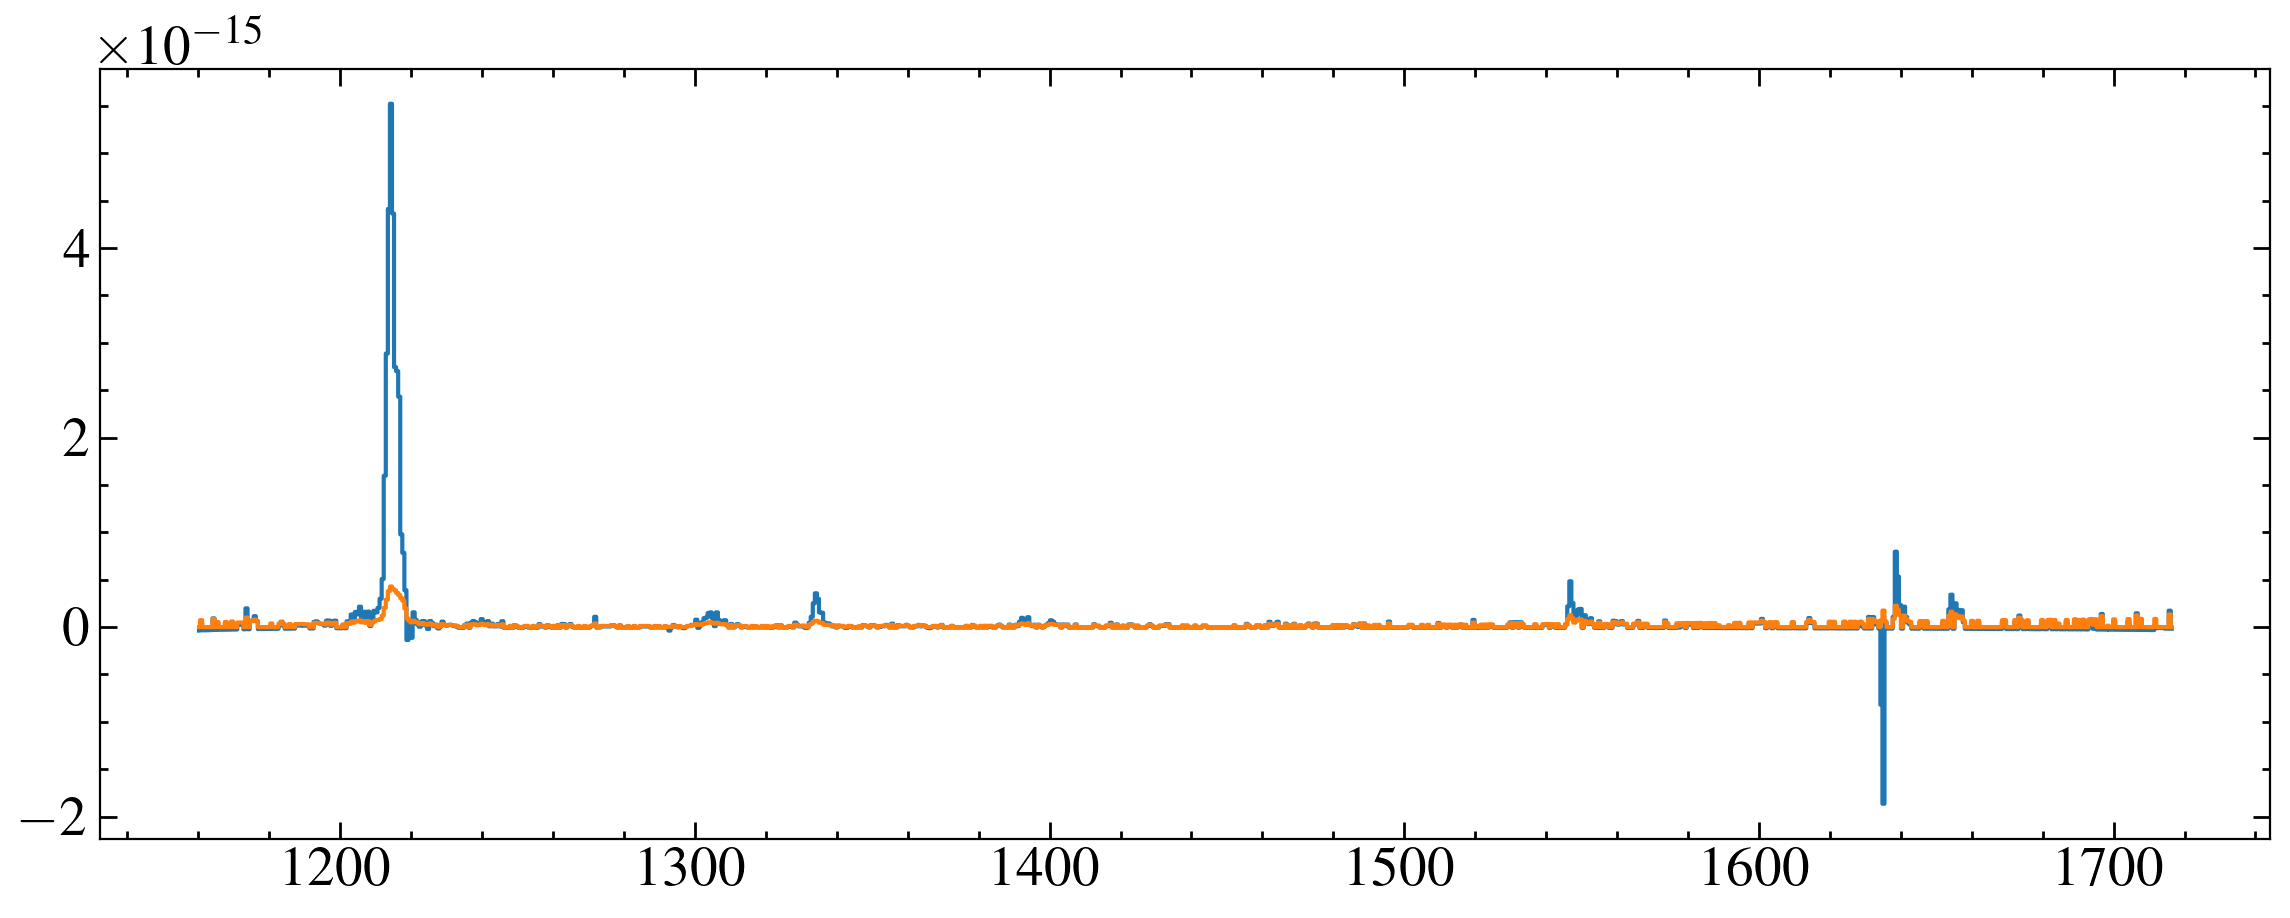

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20030_x1d.fits
[498.31918]


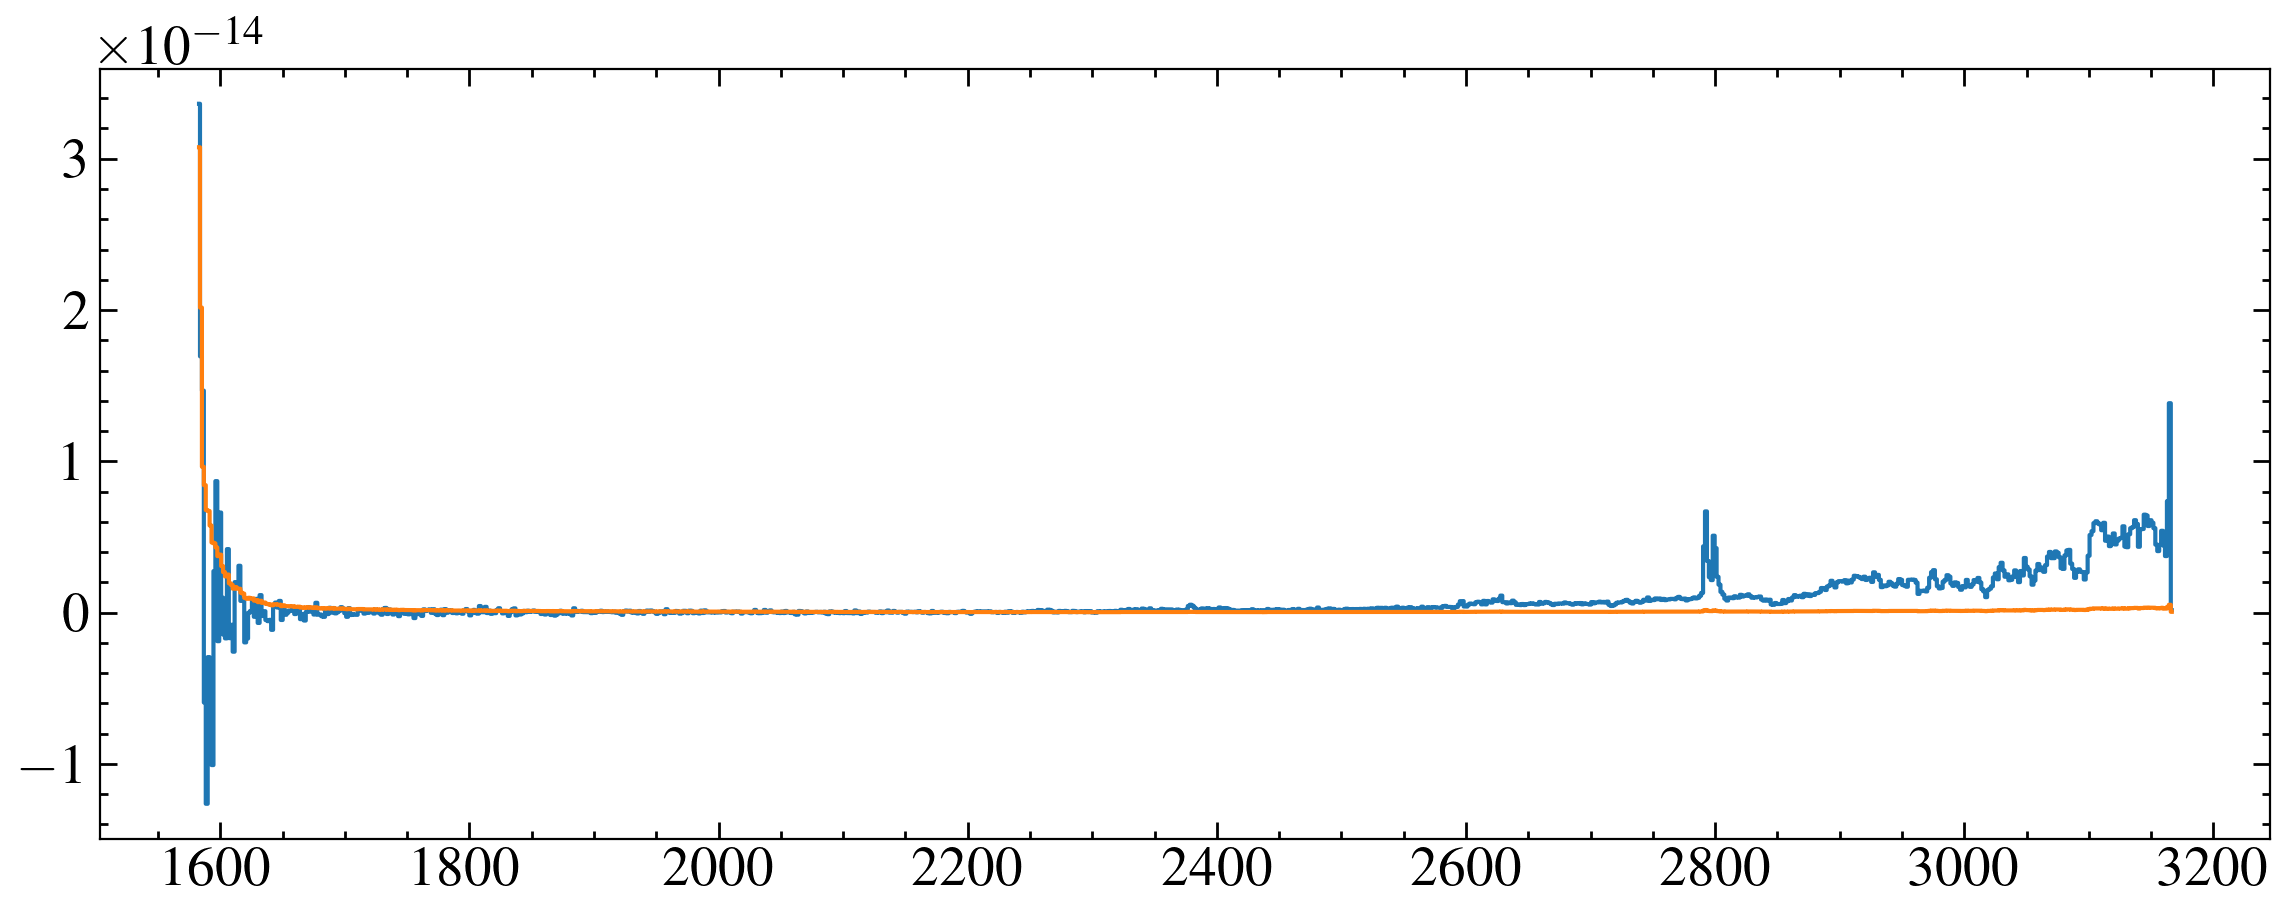

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo42010_x1d.fits
[130.67415]


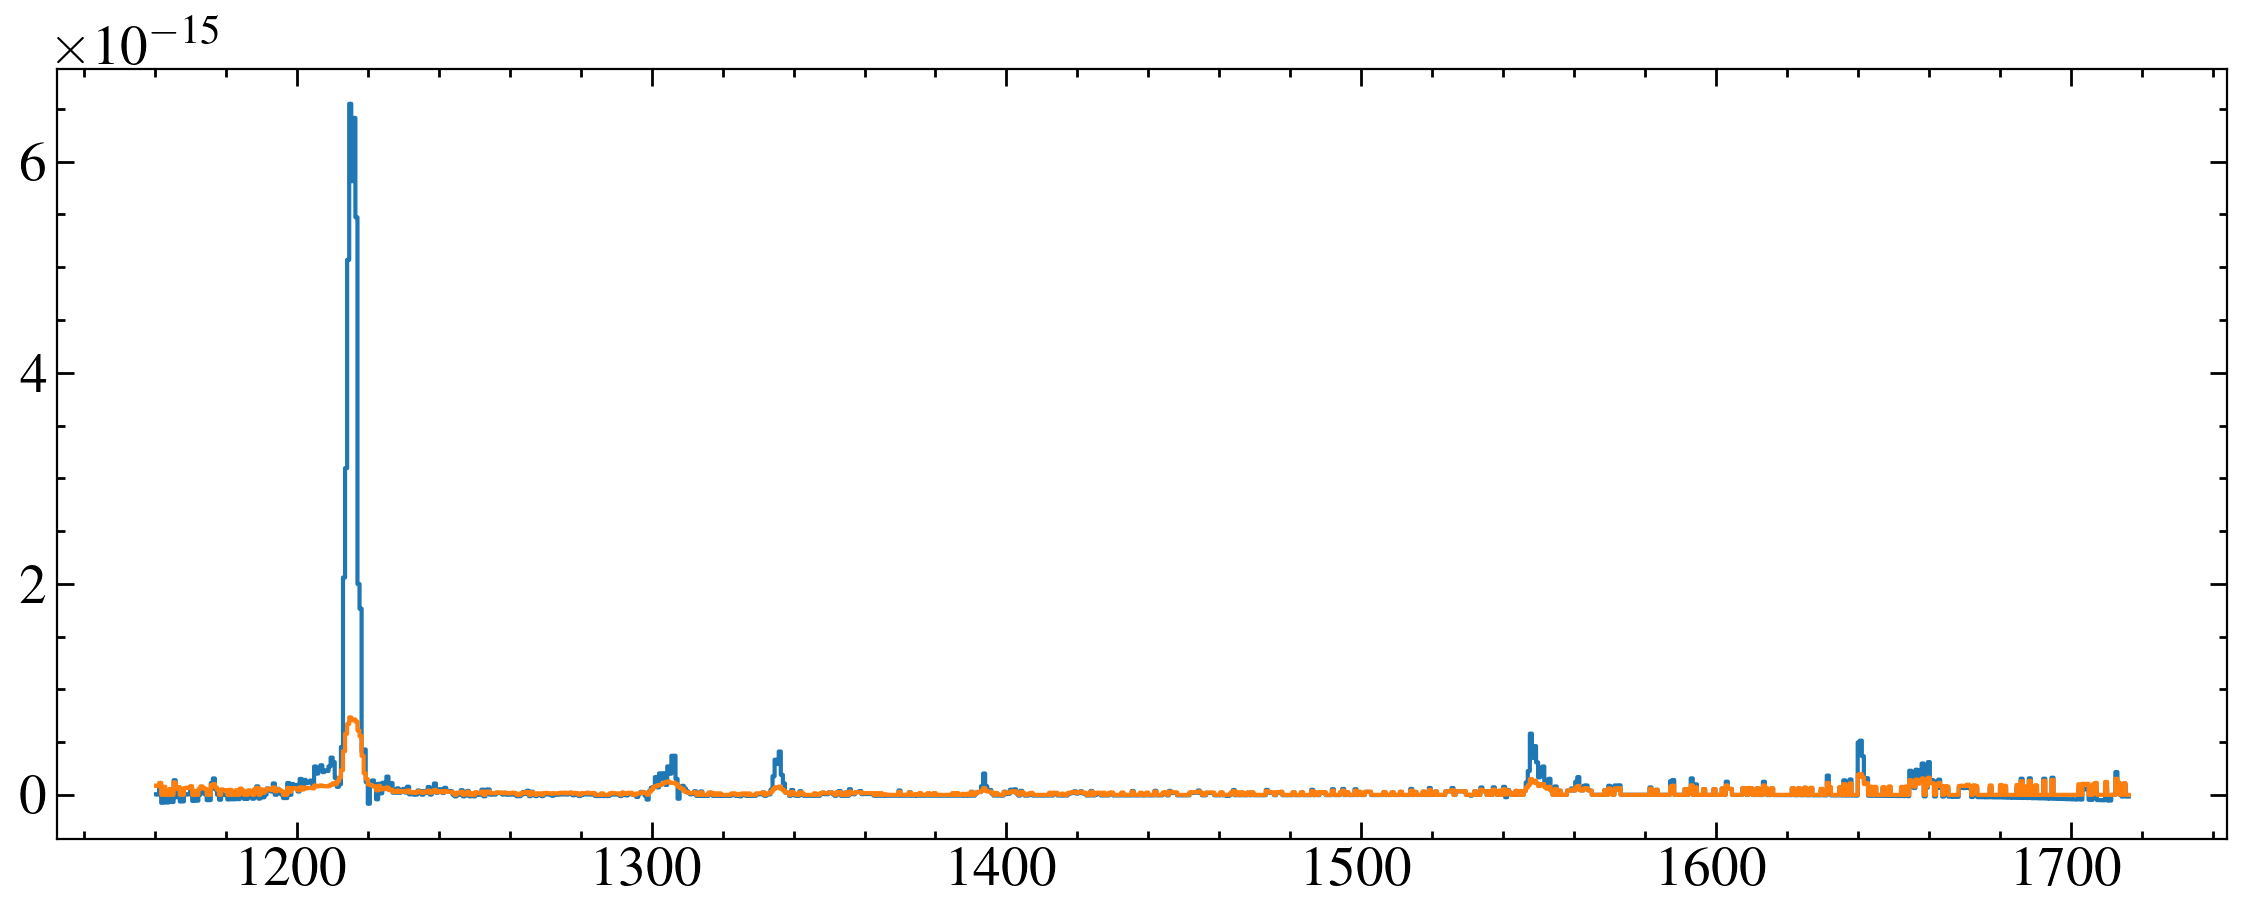

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20040_sx1.fits
[895.0867]


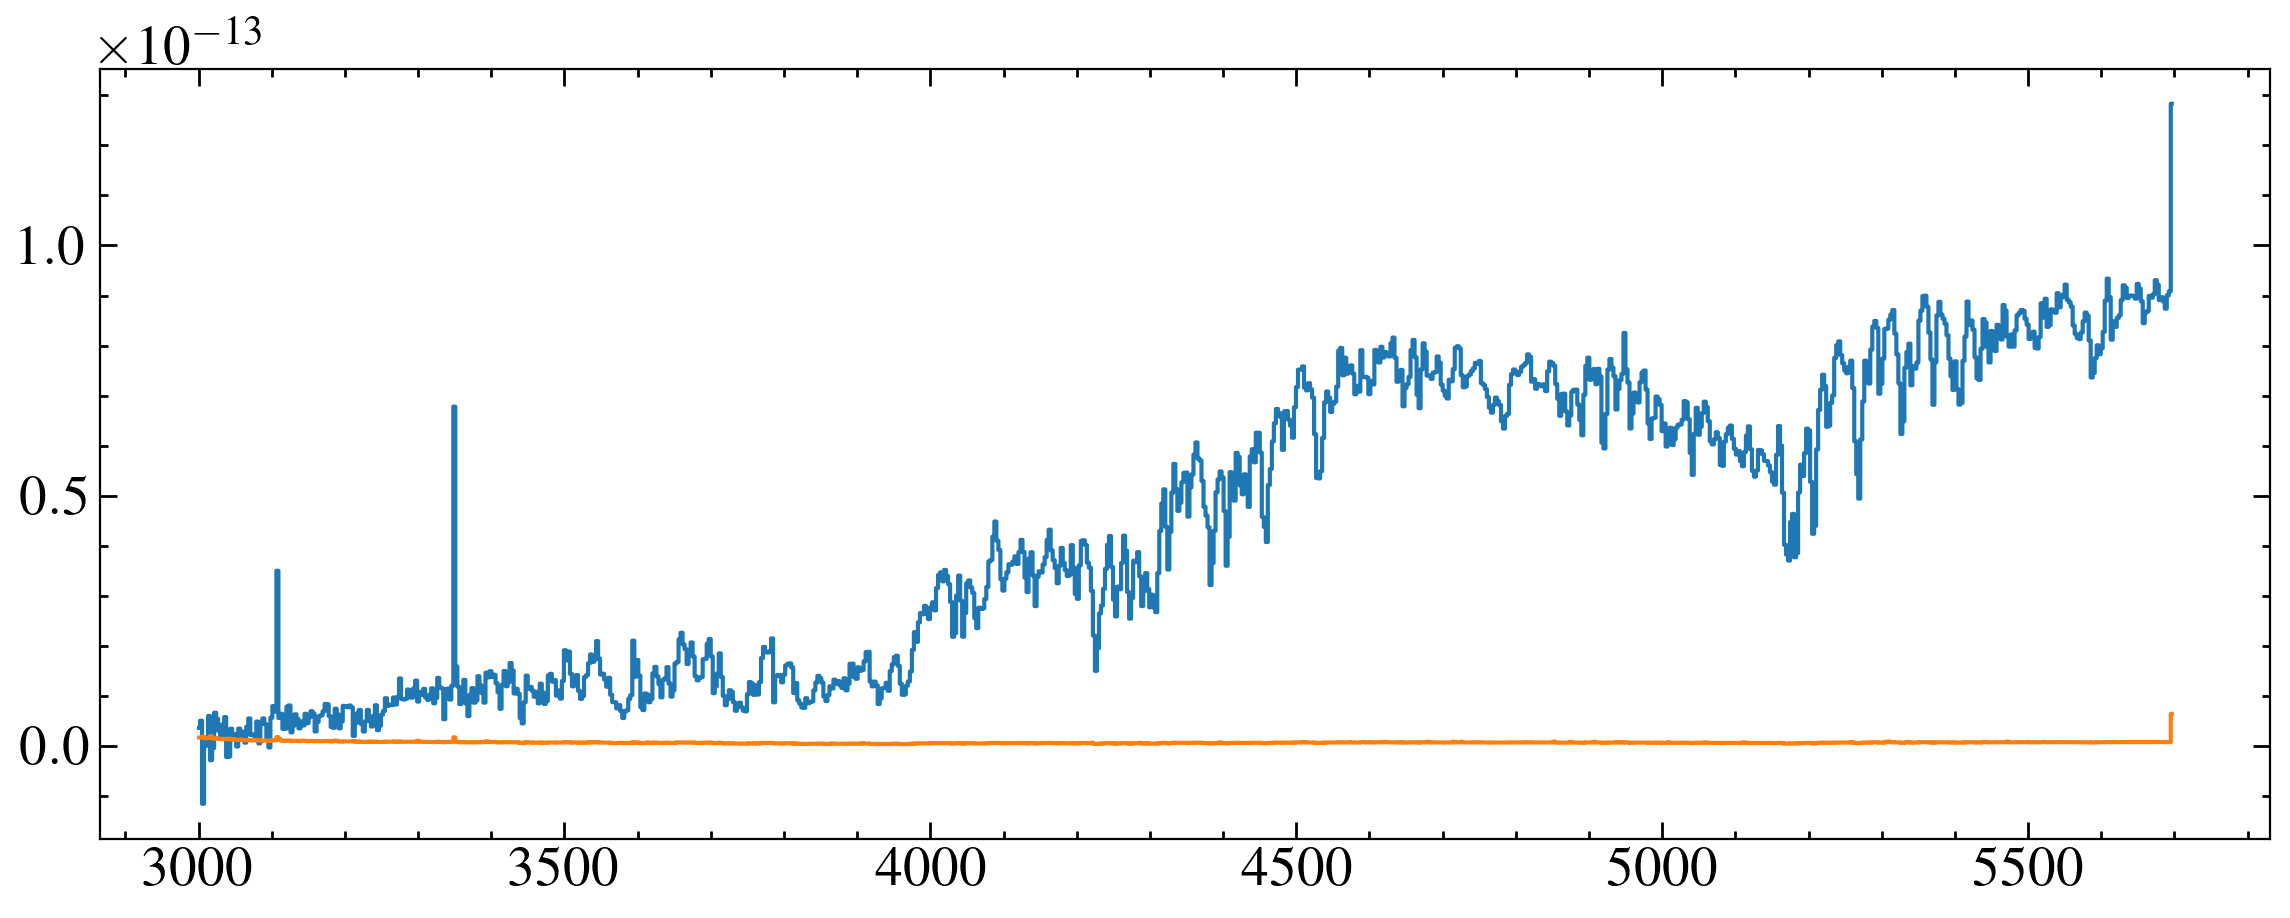

In [3]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    # print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    for dt in data:
        w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
        if grating == 'G430L':
            mask = w > 3000
        else:
            mask = w > 1160
        
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid', c='C0')
        plt.step(w, e, where='mid', c='C1')
        # plt.yscale('log')
    plt.show()

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-17)

/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:698: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


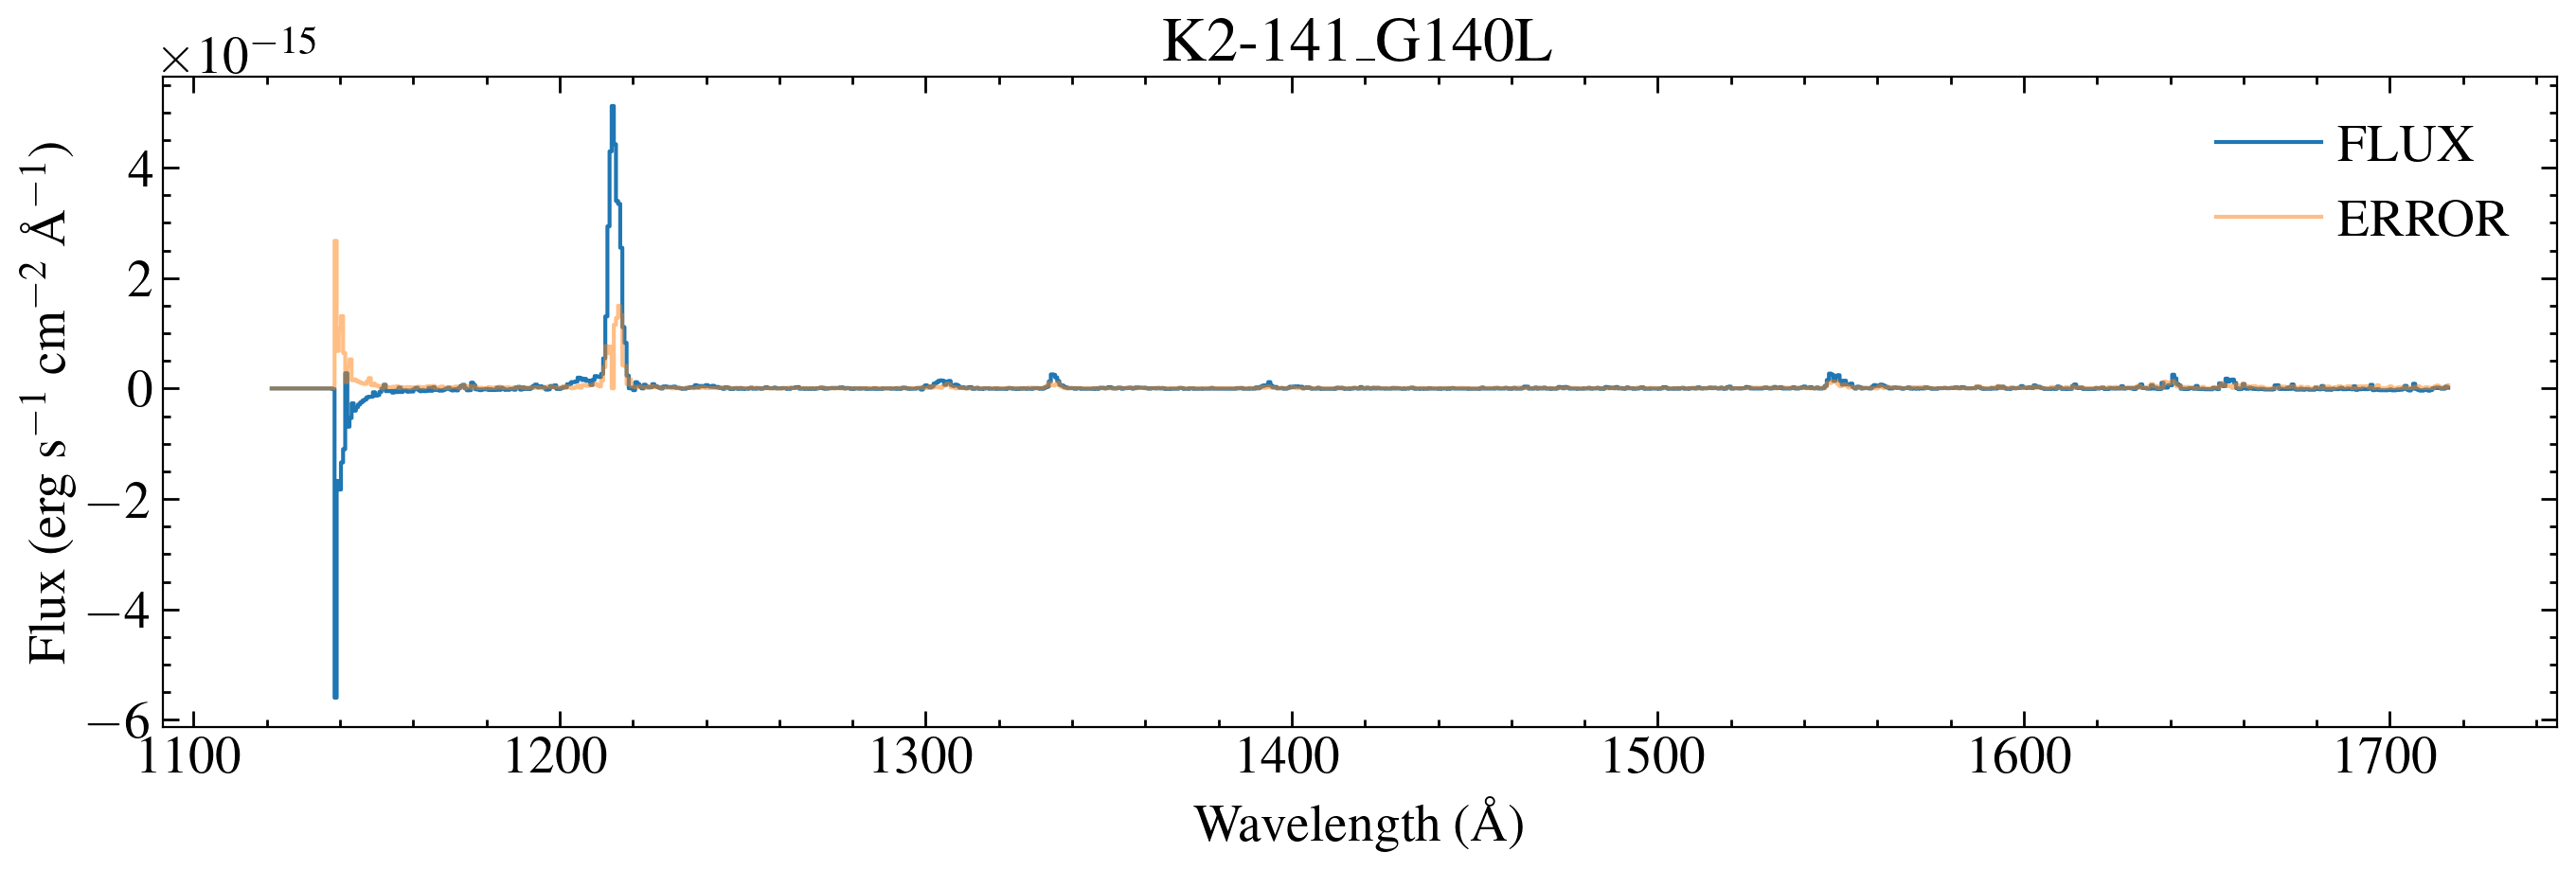

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g140l_v1_component-spec.fits


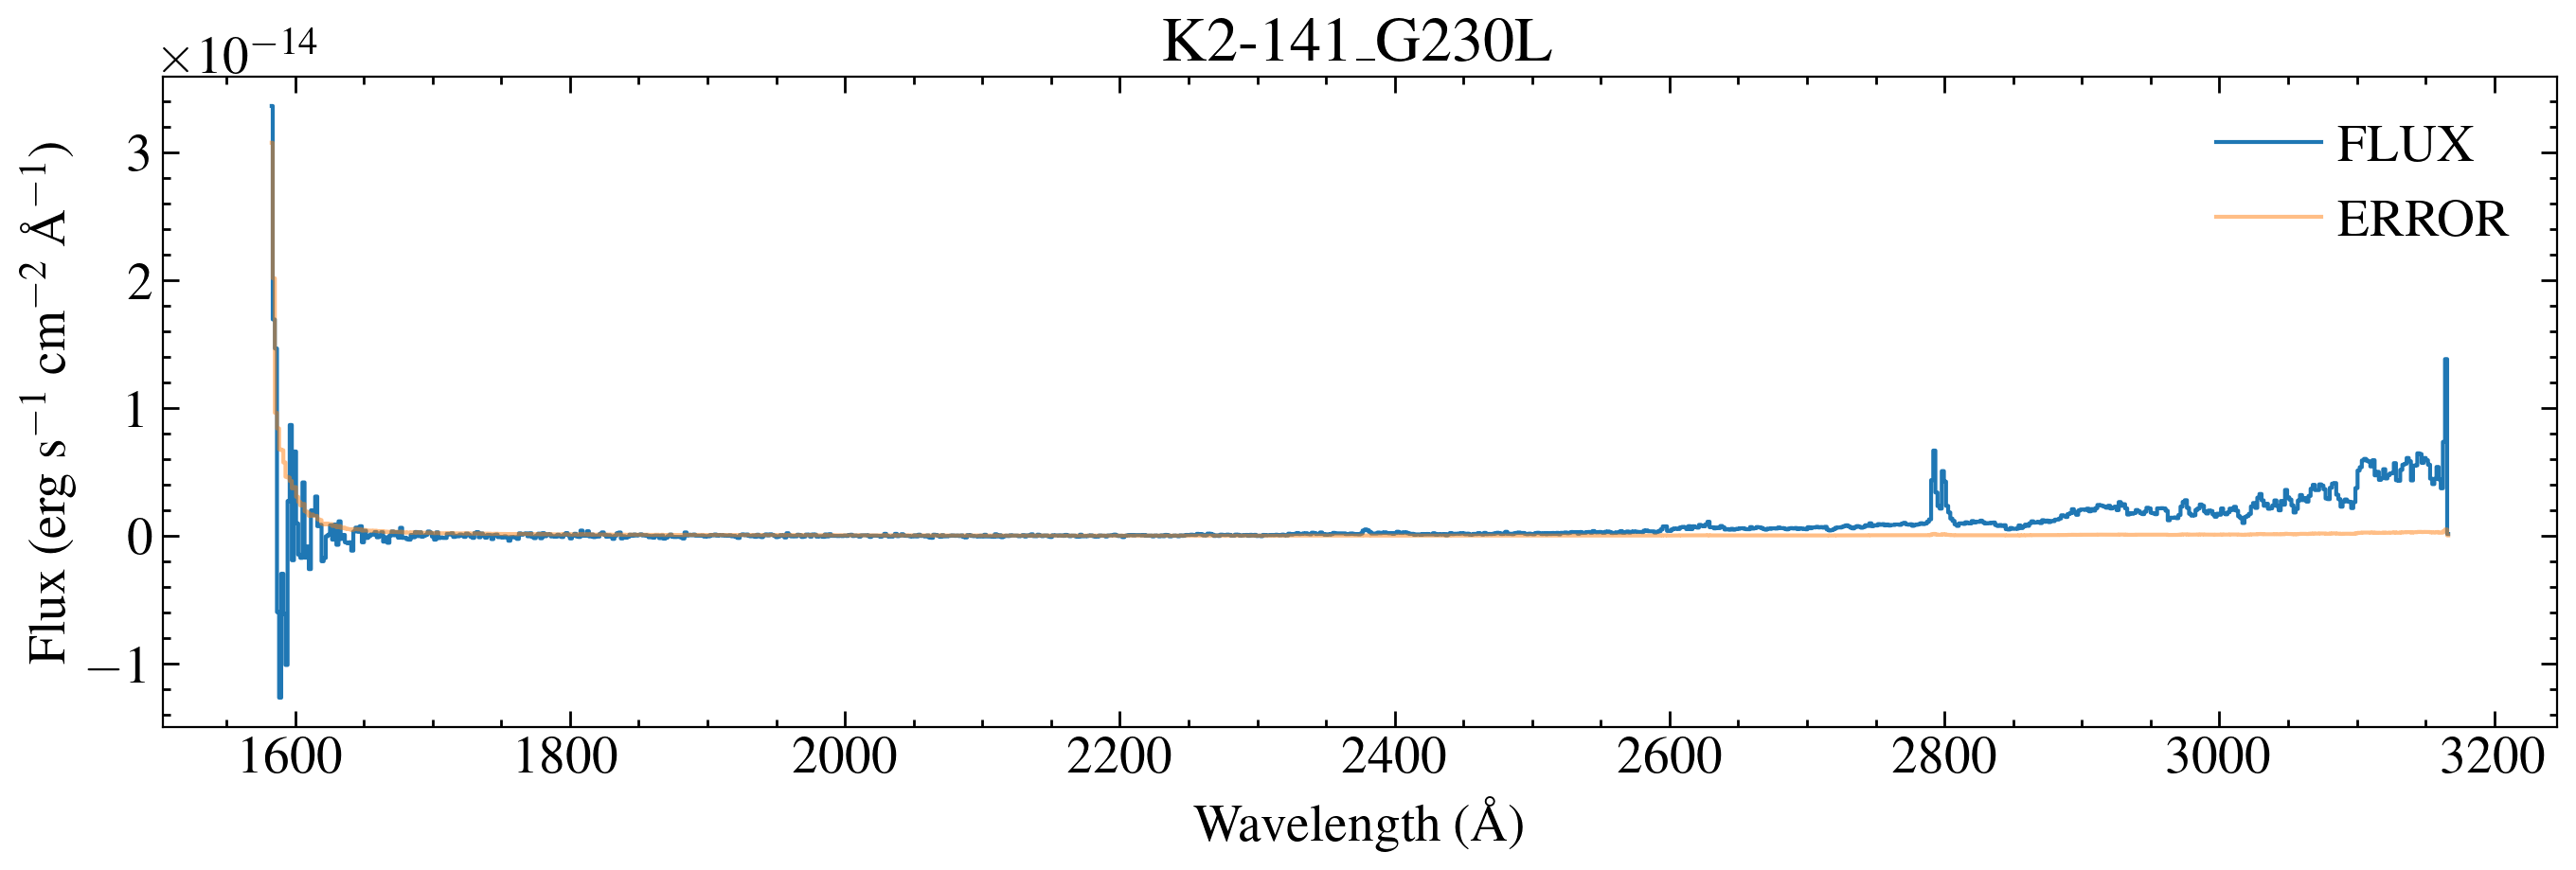

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g230l_v1_component-spec.fits


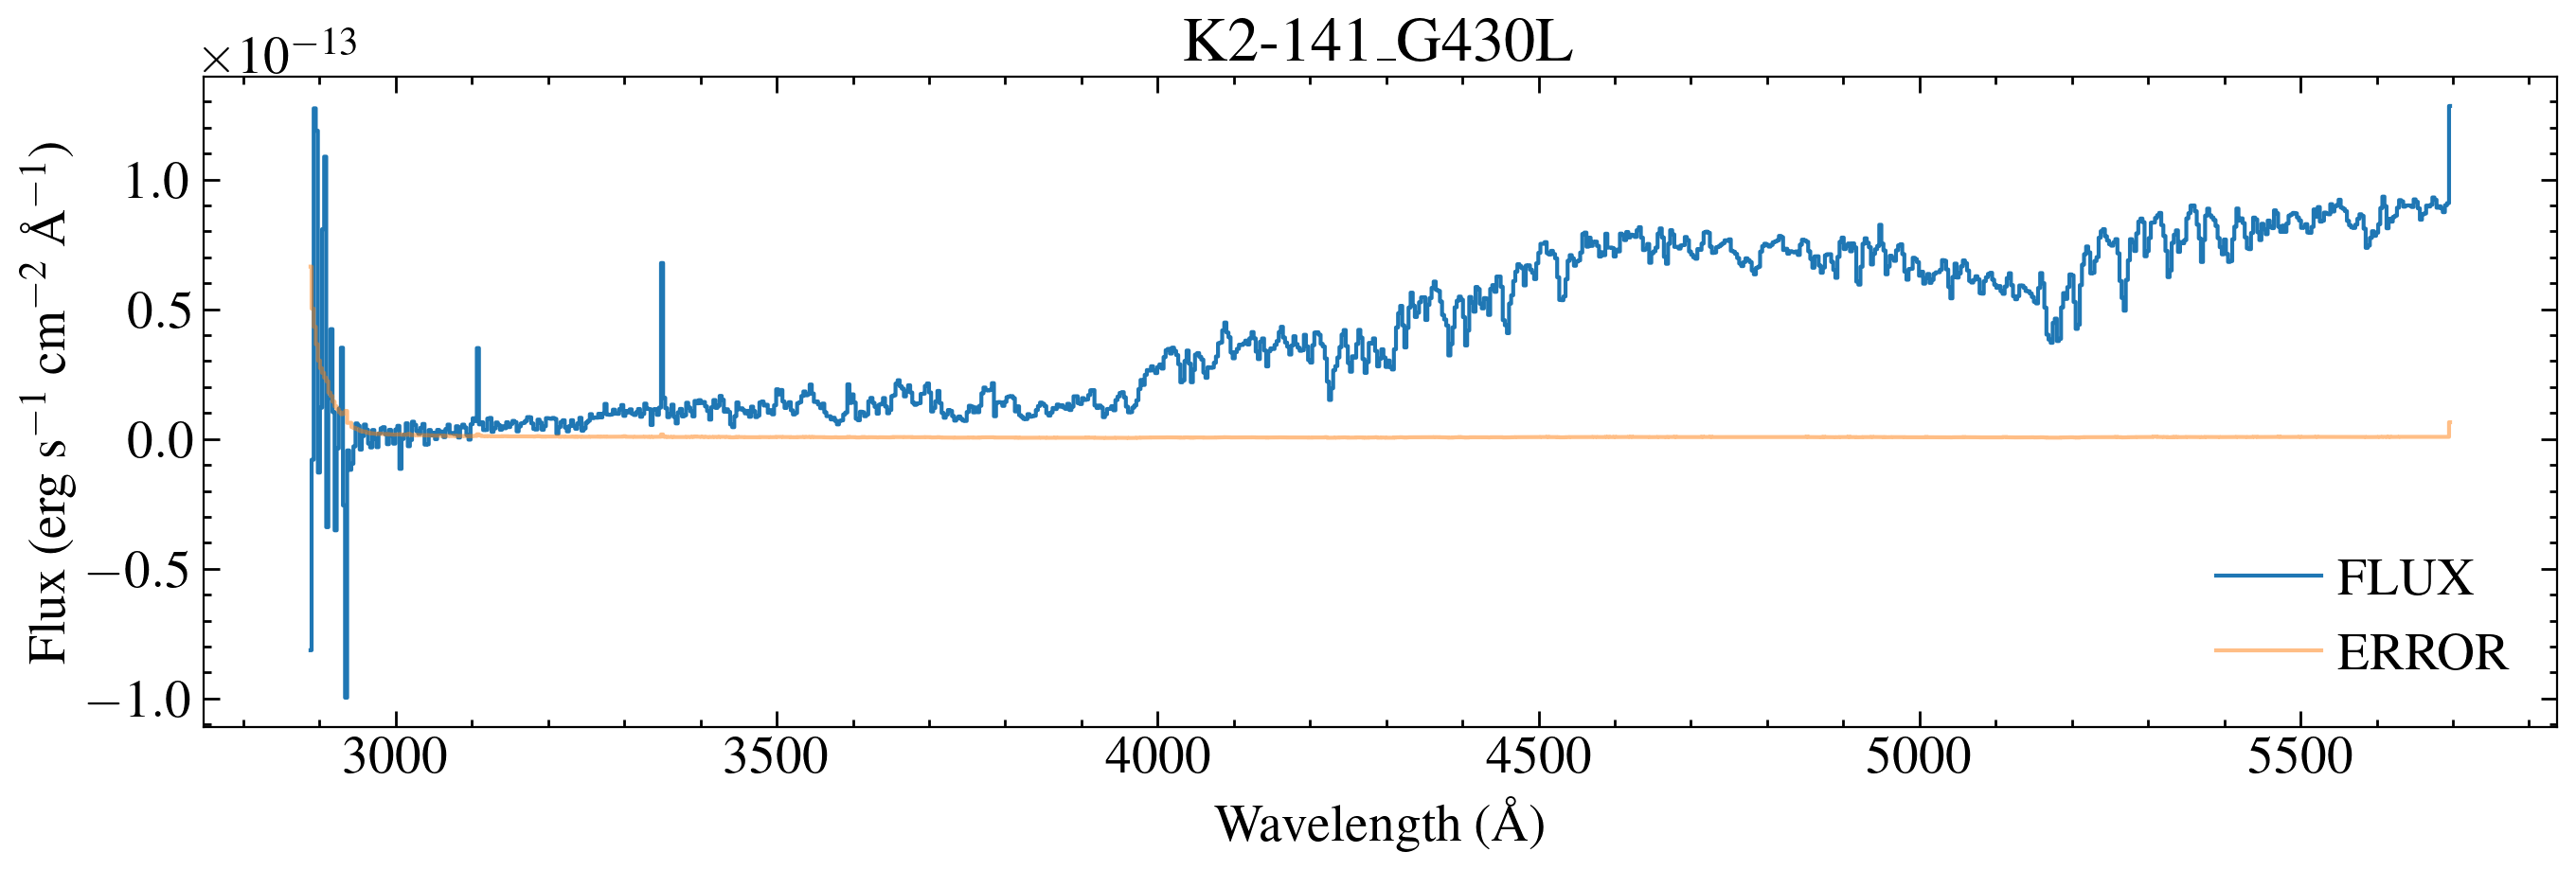

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits


In [4]:
import prepare_stis
x1dpath = path
savepath = 'draft_hlsp/k2-141/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'K2-141')